In [1]:

import tempfile
import pickle as pkl
from pathlib import Path
import sys
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [2]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config['camins']['texte']['fichier_wiki_texte']
INPUT_FICHER_WIKI_ETIQUETAS_MANUAL = config['camins']['etiquetas']['fichier_wiki_etiquetas_manual']
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config['camins']['etiquetas']['fichier_wiki_etiquetas_automatic']
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config['camins']['etiquetas']['fichier_wiki_etiquetas_entropia']
INPUT_DORSIER_TOKENIZAIRE = config['camins']['tokenizaire']['dossier_tokenizaire']

OUTPUT_PREDICCIONS = config['camins']['classificador']['prediccions']
OUTPUT_DORSIER_MODEL = config['camins']['classificador']['dossier_model']

OPTIMIZACION_BAYESIANA = False

In [3]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    lista_dialectes_df=[
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_MANUAL),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    ],
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8308,Coduras,gascon,coduras
8309,Cobluc,gascon,cobluc
8310,Michal_Kováč,lengadocian,michal ková banquièr e òme politic (ubia 5 d'a...
8311,La_Bruguièra_Dorçan,lengadocian,la bruguièra dorçan


In [4]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=0.2)

In [5]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DORSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [6]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:
    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):
            
            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)


    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.9386650631389056
Precision: 0.8154524108821217
Rappel: 0.8204150836105367
F1: 0.8139533446027363


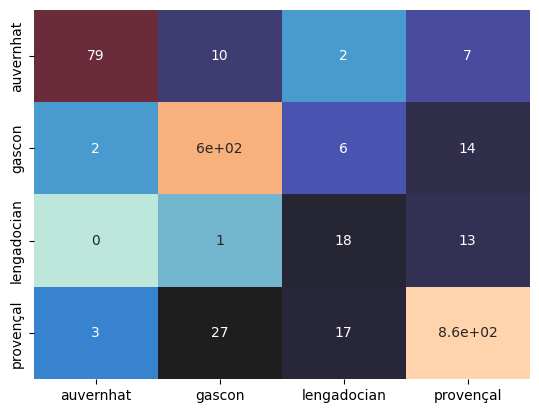

In [7]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok = True) 

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(
        **melhor_params,
    )

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    for nom_param, valor_param in melhor_params.items():
        mlflow.log_param(nom_param, valor_param)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix='.png') as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")


In [8]:
with open(Path(OUTPUT_DORSIER_MODEL) / Path('vectorizador.pkl'), 'wb') as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DORSIER_MODEL) / Path('codificador_ordinal.pkl'), 'wb') as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DORSIER_MODEL) / Path('classificador.pkl'), 'wb') as f:
    pkl.dump(xgb_final, f)

In [9]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
0,Villanueva_de_Gómez,lengadocian,0.829752,0.002579,0.050196,0.616392,0.330833,NaN
1,Anular_(anatomia),lengadocian,0.353923,0.003463,0.019203,0.913456,0.063878,NaN
2,Bauvila_(Agenés),lengadocian,0.393784,0.001478,0.025635,0.898189,0.074698,NaN
3,Compertrix,lengadocian,0.638738,0.003780,0.057547,0.799505,0.139168,NaN
4,Bongwe,gascon,0.782156,0.014414,0.678841,0.277919,0.028826,NaN
...,...,...,...,...,...,...,...,...
85540,Naintré,provençal,0.932264,0.013139,0.140969,0.195730,0.650162,NaN
85541,Cadarcet,lengadocian,1.065338,0.007180,0.185051,0.480583,0.327186,NaN
85542,Bilieg,lengadocian,0.177458,0.003146,0.006826,0.965379,0.024650,NaN
85543,Óblast_d'Arkhangelsk,lengadocian,0.822048,0.087801,0.044570,0.748755,0.118874,NaN


<Axes: xlabel='Prediccion', ylabel='Entropia'>

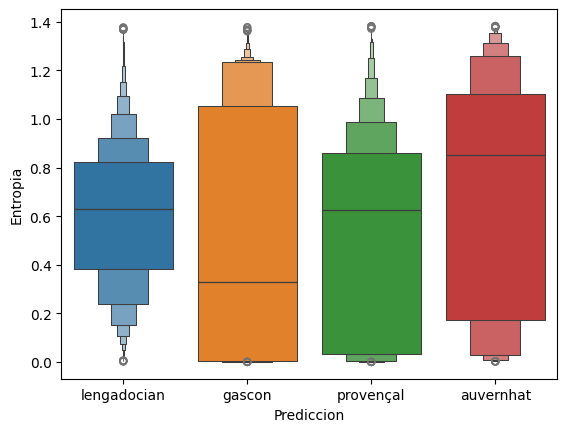

In [10]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [11]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
25703,Lengas_papós_occidentalas,lengadocian,1.376366,0.247194,0.242816,0.304593,0.205397,NaN
21047,Casinò_(omonimia),lengadocian,1.376180,0.239200,0.199711,0.296012,0.265077,NaN
25967,Lengas_jarrakanas,lengadocian,1.373197,0.214889,0.227773,0.320556,0.236782,NaN
72229,Felis_silvestris,lengadocian,1.370064,0.225624,0.278657,0.305228,0.190491,NaN
45404,Vilanòva_(omonimia),lengadocian,1.369165,0.230806,0.192703,0.320715,0.255775,NaN
55233,Chanu,lengadocian,1.367592,0.275185,0.169751,0.279537,0.275528,NaN
37641,Mietesheim,lengadocian,1.367518,0.179519,0.278302,0.305865,0.236314,NaN
62192,La_Francesa,lengadocian,1.367374,0.287774,0.217564,0.305835,0.188827,NaN
49746,Comprenhac_(Nauta_Vinhana),lengadocian,1.366691,0.180427,0.229106,0.303727,0.286741,NaN
52118,Farbauti,lengadocian,1.364746,0.218653,0.185019,0.319096,0.277232,NaN


In [12]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
43364,Caüsac_(Montanha_negra),auvernhat,1.382919,0.274303,0.251590,0.217937,0.256170,NaN
10211,Vandières,auvernhat,1.382018,0.278505,0.226667,0.227789,0.267039,NaN
57228,Lavaudieu,auvernhat,1.379246,0.280128,0.230824,0.277372,0.211676,NaN
66409,SARS,auvernhat,1.378759,0.280042,0.199913,0.261735,0.258310,NaN
54429,Missorí,auvernhat,1.378759,0.280042,0.199913,0.261735,0.258310,NaN
79974,Todt,auvernhat,1.378759,0.280042,0.199913,0.261735,0.258310,NaN
2542,Inuyasha,auvernhat,1.375242,0.298184,0.200804,0.231215,0.269797,NaN
84767,Bertrand_de_París,auvernhat,1.369822,0.284382,0.176606,0.255682,0.283331,NaN
17666,Breson,auvernhat,1.369754,0.308116,0.195875,0.216926,0.279083,NaN
58051,Solatges,auvernhat,1.367538,0.331389,0.208379,0.211864,0.248369,NaN


In [13]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       514
gascon         2855
lengadocian     164
provençal      4780
Name: Article, dtype: int64

In [14]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1542
gascon         12432
lengadocian    49859
provençal      21712
Name: Article, dtype: int64

In [15]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]
vocab_list

['00',
 '000',
 '01',
 '02',
 '03',
 '035',
 '04',
 '05',
 '06',
 '07',
 '070',
 '08',
 '10',
 '100',
 '1005',
 '1016',
 '106',
 '1099',
 '11',
 '110',
 '1106',
 '1126',
 '116',
 '117',
 '11758',
 '1185',
 '119',
 '1190',
 '12',
 '120',
 '122',
 '126',
 '127',
 '13',
 '130',
 '136',
 '139',
 '14',
 '1425',
 '144',
 '1440',
 '1448',
 '145',
 '1477',
 '15',
 '1527',
 '1560',
 '1567',
 '16',
 '1625',
 '1642',
 '1643',
 '1646',
 '1651',
 '1660',
 '1676',
 '168',
 '1683',
 '1695',
 '1697',
 '1698',
 '1699',
 '17',
 '170',
 '171',
 '1719',
 '1726',
 '1727',
 '1738',
 '1744',
 '1753',
 '1765',
 '1770',
 '1775',
 '1776',
 '1777',
 '1778',
 '1779',
 '1788',
 '1789',
 '1792',
 '1793',
 '1794',
 '1796',
 '18',
 '180',
 '1800',
 '1802',
 '1803',
 '1804',
 '1806',
 '1818',
 '1820',
 '1821',
 '1822',
 '1825',
 '1827',
 '1828',
 '1829',
 '1831',
 '1832',
 '1833',
 '1836',
 '1839',
 '184',
 '1841',
 '1843',
 '1846',
 '1847',
 '1848',
 '1849',
 '185',
 '1851',
 '1852',
 '1854',
 '1856',
 '1857',
 '186'

In [18]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [19]:
fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values('FI', ascending=False).head(60)

,FI,TokenIndex,Token
17291,0.079218,17291,ġua
9657,0.062066,9657,ġdei
2196,0.035478,2196,es
9931,0.028203,9931,ġdeu
1392,0.025972,1392,cep
17240,0.024779,17240,ġtrã²ba
12806,0.022687,12806,ġlingã¼istica
9560,0.019717,9560,ġdau
9680,0.018582,9680,ġdels
12675,0.014808,12675,ġlei
